<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/shelter-animal/shelter-animal/Shelter_Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
!pip install --upgrade --force-reinstall --no-deps kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 61 kB 566 kB/s 
     |████████████████████████████████| 186 kB 47.6 MB/s 
     |████████████████████████████████| 1.2 MB 28.5 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 298 kB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ee1a564a85e101a7dc9c07b4d4f62a27e8460c7c55742f1a859bb18f75d08f95
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Mounted at /content/gdrive


Import kaggle.json

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [98]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
import zipfile, gzip

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
!rm -r ~/shelter-animal-outcomes
!mkdir ~/shelter-animal-outcomes
    
api.competition_download_cli('shelter-animal-outcomes', path='shelter-animal-outcomes')

with zipfile.ZipFile('shelter-animal-outcomes/shelter-animal-outcomes.zip','r') as zip_ref:
    zip_ref.extractall('data')

with gzip.open('data/sample_submission.csv.gz') as f:
    sample_submission = pd.read_csv(f)

with gzip.open('data/test.csv.gz') as f:
    test = pd.read_csv(f)

with gzip.open('data/train.csv.gz') as f:
    train = pd.read_csv(f, low_memory=False)


rm: cannot remove '/root/shelter-animal-outcomes': No such file or directory


100%|██████████| 716k/716k [00:00<00:00, 87.4MB/s]

In [5]:
sample_submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


In [6]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [7]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,...,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,...,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,...,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,...,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,...,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,...,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [8]:
train['OutcomeType'].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

In [9]:
dep_var = 'OutcomeType'

In [10]:
cont, cat = cont_cat_split(train, 1 , dep_var)

In [11]:
procs = [Categorify, FillMissing]

Create TabularPandas

In [12]:
train_tabular = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=RandomSplitter(valid_pct=0.2)(range_of(train)), y_block = CategoryBlock())

In [69]:
#Outcome result from model based on index
outcomes = ['Adoption','Died','Euthanasia', 'Return_to_owner','Transfer']

In [14]:
xs,y = train_tabular.train.xs, train_tabular.train.y

valid_x,valid_y = train_tabular.valid.xs, train_tabular.valid.y

In [15]:
len(train_tabular.train), len(train_tabular.valid)

(21384, 5345)

## Get Important Features using Random Forest

Define random forest function

In [16]:
def rf(xs, y, n_estimators=25, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [17]:
m = rf(xs, y)

In [18]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [70]:
#Define error function
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [20]:
xs_drop = xs.drop(['OutcomeSubtype', 'DateTime'], axis=1)
valid_x_drop = valid_x.drop(['OutcomeSubtype','DateTime'], axis=1)

In [21]:
m = rf(xs_drop, y)

In [22]:
fi = rf_feat_importance(m, xs_drop)

In [23]:
m_rmse(m, xs_drop, y), m_rmse(m, valid_x_drop, valid_y)

(1.245885, 1.449473)

In [24]:
r_mse(m.oob_prediction_, y)

1.454037

Filter importance that has value greater than 0.005

In [25]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

7

In [26]:
xs_imp = xs_drop[to_keep]
valid_x_imp = valid_x_drop[to_keep]

In [27]:
m = rf(xs_imp, y)

In [28]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

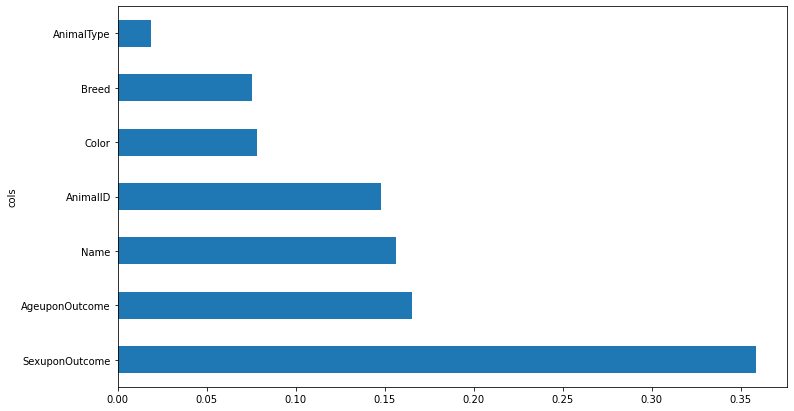

In [29]:
plot_fi(rf_feat_importance(m, xs_imp));

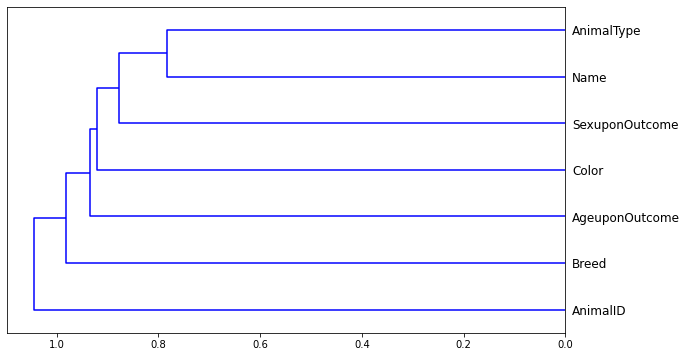

In [30]:
cluster_columns(xs_imp)

In [74]:
#Define Out Of Bag Score
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [32]:
to_drop = []

In [33]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_x_final = valid_x_imp.drop(to_drop, axis=1)

In [34]:
df_dom = pd.concat([xs_final, valid_x_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_x_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
3,AnimalID,0.302287
1,Name,0.213189
4,Color,0.154557
5,Breed,0.133993
2,AgeuponOutcome,0.129014
0,SexuponOutcome,0.054361


Try dropping each feature to check if there is a big difference or not

In [35]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_x_final, valid_y))

for c in ('AnimalID','Name'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_x_final.drop(c,axis=1), valid_y))

orig 1.447448
AnimalID 1.452118
Name 1.452422


No big difference detected, so it is safe to delete the features

In [36]:
time_vars = ['AnimalID','Name']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_x_time = valid_x_final.drop(time_vars, axis=1)

In [37]:
m = rf(xs_final_time, y)
m_rmse(m, valid_x_time, valid_y)

1.458378

## Neural Network

Initialize data

In [75]:
with gzip.open('data/train.csv.gz') as f:
    train_nn = pd.read_csv(f, low_memory=False)


train_nn = add_datepart(train_nn, 'DateTime')

In [76]:
train_nn_final = train_nn[list(xs_final_time.columns) + [dep_var]]

In [77]:
cont_nn,cat_nn = cont_cat_split(train_nn_final, max_card=2000, dep_var=dep_var)

In [78]:
cont_nn, cat_nn

([], ['SexuponOutcome', 'AgeuponOutcome', 'Color', 'Breed', 'AnimalType'])

In [79]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_nn)), y_names=dep_var, y_block = CategoryBlock())

In [80]:
dls = to_nn.dataloaders(256)

In [81]:
dls.show_batch()

,SexuponOutcome,AgeuponOutcome,Color,Breed,AnimalType,OutcomeType
0,Intact Male,1 month,Brown Tabby/White,Domestic Shorthair Mix,Cat,Transfer
1,Spayed Female,7 months,Black/White,Border Collie Mix,Dog,Adoption
2,Spayed Female,1 year,Brown Tabby,Domestic Shorthair Mix,Cat,Transfer
3,Spayed Female,11 months,Tortie,Domestic Shorthair Mix,Cat,Return_to_owner
4,Neutered Male,3 months,Orange Tabby/White,Domestic Shorthair Mix,Cat,Adoption
5,Neutered Male,1 year,Red,Catahoula Mix,Dog,Return_to_owner
6,Intact Male,9 months,Flame Point,Domestic Shorthair Mix,Cat,Euthanasia
7,Neutered Male,6 years,Brown Tabby/White,Domestic Shorthair Mix,Cat,Return_to_owner
8,Neutered Male,1 year,Brown,Australian Shepherd Mix,Dog,Adoption
9,Neutered Male,2 months,Red/White,Anatol Shepherd,Dog,Adoption


Create learner

In [86]:
learn = tabular_learner(dls, layers=[500,250], loss_func= CrossEntropyLossFlat(), metrics=[accuracy, error_rate])

SuggestedLRs(valley=0.0006918309954926372)

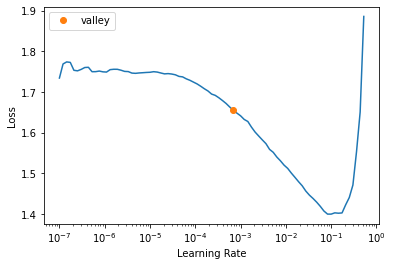

In [87]:
learn.lr_find()

In [88]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.009034,0.880576,0.637605,0.362395,00:01
1,0.880333,0.867875,0.648644,0.351356,00:01


SuggestedLRs(valley=0.0030199517495930195)

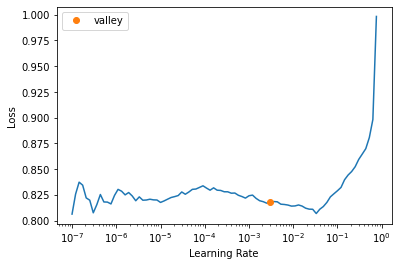

In [89]:
learn.lr_find()

In [90]:
learn.fit_one_cycle(4, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.818079,0.867393,0.647334,0.352666,00:01
1,0.809298,0.868119,0.647147,0.352853,00:01
2,0.805568,0.869026,0.648644,0.351356,00:01
3,0.804253,0.870198,0.646773,0.353227,00:01


In [91]:
learn.show_results()

,SexuponOutcome,AgeuponOutcome,Color,Breed,AnimalType,OutcomeType,OutcomeType_pred
0,2,28,217,641,1,4,4
1,4,31,290,1067,2,3,3
2,2,30,6,641,1,4,4
3,4,27,12,960,2,0,0
4,4,33,275,848,2,4,0
5,1,21,297,641,1,4,4
6,4,20,39,891,2,4,0
7,3,20,319,638,1,0,0
8,2,11,115,1366,2,3,2


Get predictions

In [92]:
test_dl = learn.dls.test_dl(test)
predictions = learn.get_preds(dl=test_dl)

In [97]:
x_df = pd.DataFrame(predictions[0])
x_df.rename(columns = dict(enumerate(outcomes)), inplace = True)
x_df

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0.023863,0.017334,0.071357,0.055552,0.831894
1,0.654624,0.001706,0.019631,0.217460,0.106578
2,0.392714,0.003034,0.021308,0.116444,0.466499
3,0.043317,0.015321,0.100533,0.080115,0.760714
4,0.548285,0.002113,0.012873,0.255147,0.181582
...,...,...,...,...,...
11451,0.905492,0.000972,0.001591,0.008978,0.082967
11452,0.001190,0.009664,0.025068,0.005084,0.958994
11453,0.010268,0.010868,0.079539,0.010069,0.889256
11454,0.422110,0.002758,0.041239,0.390562,0.143331


In [71]:
x_df.to_csv('result.csv')